In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import random

In [71]:
path = os.getcwd() + '/historical_price'
stock08 = []
for file in os.listdir(path):
    if "AAPL" in file or "GOOG_" in file:
        file_path = path + '/' + file
        date = pd.read_csv(file_path)['t']
        if len(date)>0:
            stock08.append(file)
print(str(len(stock08))+" stocks selected")
print(stock08)

2 stocks selected
['GOOG_2015-12-30_2021-02-21_minute.csv', 'AAPL_2015-12-30_2021-02-21_minute.csv']


In [76]:
stock_price_dict = {}

for file in stock08 :
    path = os.getcwd() + '/historical_price/' + file
    df = pd.read_csv(path)
    #df = df[df.t >= '2018-09-10']
    df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d')# utc = True)
    df = df.set_index(pd.DatetimeIndex(df['t']))
    df = df.resample('B').mean()
    stock_price_dict[file.split("_")[0]] = df['c']
    
stock_price_df = pd.DataFrame(stock_price_dict)


In [77]:

stock_price_df.head()

,GOOG,AAPL
t,,
2015-12-30,774.039912,26.937073
2015-12-31,764.890341,26.461507
2016-01-01,763.000000,26.358750
2016-01-04,736.814417,26.004184
2016-01-05,744.864791,25.930656


In [74]:
stock_price_df

,GOOG,AAPL
t,,
2015-12-30,774.039912,26.937073
2015-12-31,764.890341,26.461507
2016-01-01,763.000000,26.358750
2016-01-04,736.814417,26.004184
2016-01-05,744.864791,25.930656
...,...,...
2021-02-12,2097.768981,134.704289
2021-02-15,NaN,NaN
2021-02-16,2131.403552,134.242484


In [78]:
stock_price_df.drop(stock_price_df.tail(2).index, 
            inplace = True) 
stock_price_df

,GOOG,AAPL
t,,
2015-12-30,774.039912,26.937073
2015-12-31,764.890341,26.461507
2016-01-01,763.000000,26.358750
2016-01-04,736.814417,26.004184
2016-01-05,744.864791,25.930656
...,...,...
2021-02-10,2089.274239,135.709714
2021-02-11,2087.563352,135.009672
2021-02-12,2097.768981,134.704289


In [79]:
NA_col = []
NA_ratio = []
for col in stock_price_df.columns :
    na_index = np.where(stock_price_df[col].isnull())[0]
    NA_col.append(col)
    NA_ratio.append(len(na_index)/stock_price_df.shape[0] * 100)
    print(col,na_index)
NA_df = pd.DataFrame({'tickers':NA_col,'NA_ratio':NA_ratio})

GOOG [  13   33   62  108  133  178  258  263  273  298  337  368  394  438
  518  523  533  558  587  628  655  698  756  765  779  784  798  818
  862  888  916  958 1021 1040 1045 1058 1078 1117 1148 1177 1223 1281
 1302 1307 1318 1338]
AAPL [  13   33   62  108  133  178  258  263  273  298  337  368  394  438
  518  523  533  558  587  628  655  698  779  798  818  862  888  916
  958 1040 1058 1078 1117 1148 1177 1223 1302 1318 1338]


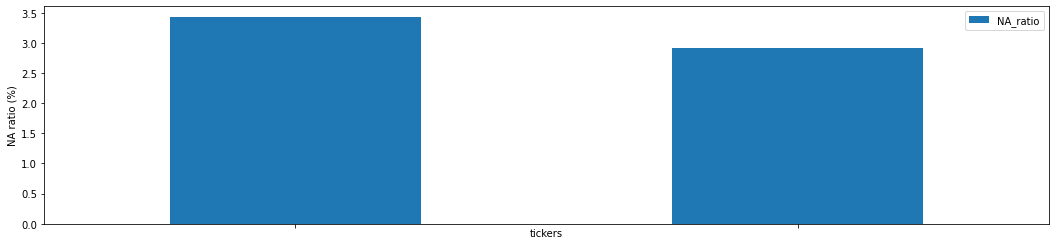

In [80]:
NA_df.plot.bar(rot=0, figsize=(18,4))
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
plt.xlabel('tickers')
plt.ylabel('NA ratio (%)')
plt.show()
plt.close()

In [81]:
def impute_data(column_name):
    index = stock_price_df.index.values[0]
    price_na_index = np.where(stock_price_df[column_name].isnull())[0]
    for i in price_na_index :
        stock_price_df[column_name][i] = stock_price_df[column_name][i-1]

In [82]:
for item in stock_price_df.columns :
    impute_data(item)

In [83]:
# Final Check for NaN
for item in stock_price_df.columns :
    if stock_price_df[item].isnull().values.any() :
        print('stock price data of '+item+' still has NaN')
print("END OF CHECKING. NO NA REMAINING")

END OF CHECKING. NO NA REMAINING


In [84]:
stock_price_df.to_csv("2stock_price.csv",index_label='Date')

In [85]:
df = pd.read_csv("2stock_price.csv")
universe = list(df.columns.values[1:])
print("2stock_price shape: " + str(df.shape))
print(universe)

2stock_price shape: (1340, 3)
['GOOG', 'AAPL']


In [86]:
portfolio = universe
print("Portfolio size: " + str(len(portfolio)) + '\n' + str(portfolio))

Portfolio size: 2
['GOOG', 'AAPL']


In [87]:
portfolio[0]

'GOOG'

## Prepare the data

In [89]:
window = int(1340/20) # OG was 100
def rolling_corr(item1,item2) :
    #import data
    stock_price_df = pd.read_csv("2stock_price.csv")
    pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
    stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
    
    #calculate
    df_pair = pd.concat([stock_price_df[item1], stock_price_df[item2]], axis=1)
    df_pair.columns = [item1,item2]
    df_corr = df_pair[item1].rolling(window=window).corr(df_pair[item2])
    return df_corr


In [111]:
index_list = []
for _ in range(window):
    indices = []
    for k in range(_, 1274,window):
        indices.append(k)
    index_list.append(indices)


In [114]:
data_matrix = []
count = 0
a = portfolio[0]
b = portfolio[1]
file_name = a + '_' + b
corr_series = rolling_corr(a, b)[(window-1):]
for _ in range(window):
    corr_strided = list(corr_series[index_list[_]][:24]).copy()
    data_matrix.append(corr_strided)
              

In [131]:
data_matrix = np.transpose(data_matrix)
data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame.from_dict(data_dictionary, orient='index')

#data_df = pd.DataFrame(data_dictionary)
data_df[19] = 0
data_df.to_csv('2stockdataset.csv')
data_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.655822,0.823453,0.858763,0.806041,0.702897,0.695554,-0.404459,0.759836,0.452655,0.672140,-0.434731,0.157505,0.918724,0.518488,0.904792,0.950000,0.977563,0.700433,0.478596,0
1,0.644544,0.819040,0.849098,0.813685,0.693857,0.684474,-0.354996,0.761730,0.446830,0.679516,-0.386140,0.145905,0.886592,0.510782,0.907184,0.950347,0.975588,0.701560,0.475535,0
2,0.640447,0.815833,0.835242,0.821811,0.683387,0.676004,-0.305839,0.761036,0.450617,0.672321,-0.326206,0.145704,0.864134,0.496207,0.911336,0.949857,0.972373,0.693360,0.472455,0
3,0.635507,0.813400,0.829932,0.828031,0.671143,0.665761,-0.288123,0.750677,0.452858,0.659859,-0.247964,0.178312,0.850814,0.486202,0.914923,0.947915,0.969208,0.687585,0.467547,0
4,0.639387,0.810073,0.821886,0.835662,0.660996,0.653544,-0.260983,0.745073,0.446870,0.654913,-0.220923,0.145316,0.837044,0.483995,0.921812,0.946908,0.967107,0.687108,0.460076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.840156,0.891735,0.807790,0.771400,0.720328,-0.392001,0.797336,0.503957,0.678814,-0.428524,0.376370,0.955994,0.445409,0.836487,0.953643,0.978846,0.775470,0.553619,0.496440,0
63,0.838520,0.885339,0.799003,0.766228,0.718090,-0.435977,0.783329,0.488376,0.671218,-0.434994,0.333156,0.956764,0.455424,0.859135,0.953165,0.978691,0.752209,0.536752,0.508002,0
64,0.836792,0.879354,0.798750,0.753796,0.714702,-0.448085,0.774139,0.475211,0.671332,-0.453247,0.284400,0.956084,0.476032,0.872303,0.950360,0.978444,0.734899,0.510965,0.508993,0
65,0.833537,0.872072,0.799120,0.734875,0.712130,-0.457659,0.768843,0.463276,0.671749,-0.465046,0.244361,0.955946,0.506129,0.881239,0.949626,0.978112,0.715693,0.496301,0.510434,0
